# Clasificación de secuencias de texto con BERT y Lightning

> Objetivos:



*   Procesar una base de datos de texto y adapatarla a lightning.
*   Importar modelo BERT pre-entrenado.
*   Hacer finetuning de BERT para detección de comentarios negativos o tóxicos.


## Importar librerias

In [1]:
# !pip install --upgrade kagglehub
# !pip install --upgrade polars
# !pip install --upgrade transformers

In [2]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import random_split, Dataset, DataLoader
from torch.optim import AdamW

from transformers import BertTokenizerFast as BertTokenizer, BertModel, get_linear_schedule_with_warmup

import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from torchmetrics import AUROC, Accuracy

#nuevas librerias
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os
import glob
import zipfile
import tempfile

In [3]:
# Parametros para gráficos

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8,6

pl.seed_everything(RANDOM_SEED)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

## Dataset

El dataset IMDB contiene 50,000 reseñas de películas etiquetadas como positivas o negativas. Fue descargado desde Kaggle usando el repositorio [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).


In [4]:
# Descargar la base de datos
#!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

Dado que son solo 68.8M de datos, los cargamos en memoria:

In [5]:
# BEFORE importing kagglehub
from google.colab import userdata

# Mock userdata.get to return None immediately
_original_get = userdata.get
userdata.get = lambda key: None  # Skip all secret prompts

# Descargar la última versión
dataset_path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Dataset path:", dataset_path)

# Si es un ZIP, extraer a directorio temporal
if os.path.isfile(dataset_path) and dataset_path.lower().endswith(".zip"):
    extract_dir = tempfile.mkdtemp()
    with zipfile.ZipFile(dataset_path, "r") as z:
        z.extractall(extract_dir)
    search_dir = extract_dir
else:
    search_dir = dataset_path

# Buscar archivos CSV
csv_files = glob.glob(os.path.join(search_dir, "**", "*.csv"), recursive=True)
if not csv_files:
    raise FileNotFoundError(f"No CSV files found under {search_dir}")

csv_file = csv_files[0]
print("Using CSV:", csv_file)

# Leer con pandas (fallback de encoding si falla)
try:
    df = pd.read_csv(csv_file)
except UnicodeDecodeError:
    df = pd.read_csv(csv_file, encoding="latin1")

print(df.shape)
df.head()

Dataset path: /home/eaguayo/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1
Using CSV: /home/eaguayo/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1/IMDB Dataset.csv
(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
#df = pd.read_csv("toxic_comments.csv")
#df.head()

Las reseñas de películas están en la columna `review` y las etiquetas de sentimiento en la columna `sentiment` (positive/negative). 

Para adaptar el código original de clasificación multi-etiqueta a clasificación binaria de sentimientos, creamos una columna `is_offensive` que mapea:
- negative → 1 (considerado como "ofensivo" para el modelo)  
- positive → 0 (considerado como "no ofensivo" para el modelo)

<!-- Descripción original comentada:
Las secuencias de texto están en la columna comment_text. Existen seis etiquetas que clasifican cada secuencia como tóxica, severamente tóxica, obscena, etc. Las columnas con comentarios no ofensivos tienen un 0 en todas las clases.

Separamos los comentarios ofensivos de los no ofensivos:
-->

In [7]:
#LABEL_COLUMNS = df.columns.tolist()[2:]
#df_toxic = df[df[LABEL_COLUMNS].sum(axis=1) > 0]
#df_clean = df[df[LABEL_COLUMNS].sum(axis=1) == 0]
#print("Cantidad de secuencias de texto ofensivos: ", len(df_toxic))
#print("Cantidad de secuencias de texto NO ofensivos: ", len(df_clean))

In [8]:
# Convertir el dataset IMDB para clasificación binaria
# Mapea 'negative' a 1 (ofensivo) y 'positive' a 0 (no ofensivo)
df['is_offensive'] = df['sentiment'].map({'negative': 1, 'positive': 0})

# Renombrar columnas para compatibilidad con el código existente
df = df.rename(columns={'review': 'comment_text'})

# Crear columna de etiquetas numéricas para el modelo
df['label'] = df['is_offensive']

# Filtra por sentimiento
df_origin = df[df['is_offensive'] == 1]  # Negativos (tratados como ofensivos)
df_clean = df[df['is_offensive'] == 0]   # Positivos (tratados como no ofensivos)

print("Cantidad de reseñas negativas (tratadas como ofensivas): ", len(df_origin))
print("Cantidad de reseñas positivas (tratadas como no ofensivas): ", len(df_clean))
print("Distribución de sentimientos:")
print(df['sentiment'].value_counts())

Cantidad de reseñas negativas (tratadas como ofensivas):  25000
Cantidad de reseñas positivas (tratadas como no ofensivas):  25000
Distribución de sentimientos:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


El dataset IMDB ya está balanceado (25,000 reseñas positivas y 25,000 negativas), pero para mantener la compatibilidad con el código original, ajustamos el tamaño si es necesario.

<!-- Comentario original:
Debido al desbalance de datos, tomamos un número reducido de secuencias no ofensivas para evitar bias en el modelo.
-->

In [9]:
# El dataset IMDB ya está balanceado (25k positivas, 25k negativas)
# Usar todo el dataset o una muestra si se requiere menos datos para pruebas rápidas

# Para mantener compatibilidad con el código original:
filter_df = pd.concat([
    df_origin,      # Todas las reseñas negativas (25,000)
    df_clean        # Todas las reseñas positivas (25,000)
])

# Si quieres usar solo una muestra para pruebas más rápidas, descomenta:
# filter_df = pd.concat([
#     df_origin.sample(5000, random_state=42),
#     df_clean.sample(5000, random_state=42)
# ])

print(f"Tamaño del dataset filtrado: {filter_df.shape}")
print("Distribución final:")
print(filter_df['sentiment'].value_counts())

Tamaño del dataset filtrado: (50000, 4)
Distribución final:
sentiment
negative    25000
positive    25000
Name: count, dtype: int64


In [10]:
train_frac, val_frac, test_frac = 0.7, 0.15, 0.15

# Shuffle the DataFrame
filter_df = filter_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Calcular los indices para separar los subsets
train_end = int(train_frac * len(filter_df))
val_end = train_end + int(val_frac * len(filter_df))

# Split the DataFrame
train_df = filter_df[:train_end]
val_df = filter_df[train_end:val_end]
test_df = filter_df[val_end:]

print("Train DataFrame:\n", len(train_df))
print("Validation DataFrame:\n", len(val_df))
print("Test DataFrame:\n", len(test_df))

Train DataFrame:
 35000
Validation DataFrame:
 7500
Test DataFrame:
 7500


In [11]:
train_df.head()

,comment_text,sentiment,is_offensive,label
0,"Hello, I was wondering if anyone has a copy of...",positive,0,0
1,"My Caddy Limo was destroyed!!! Well, I had one...",negative,1,1
2,A truly muddled incomprehensible mess. Most th...,negative,1,1
3,"My friends and I rented this for ""Bad Movie Ni...",negative,1,1
4,This was the very first kung fu movie that I h...,positive,0,0


## Preprocessing


### Tokenization



Convertir texto en una lista de tokens. usamos BertTokenizer pre-entrenado.

BertTokenizer: Pretrained model on English language using a masked language modeling (MLM) objective. This model is case-sensitive: it makes a difference between english and English.
The texts are tokenized using WordPiece and a vocabulary size of 30,000.

Más información en: https://huggingface.co/google-bert/bert-base-cased

In [12]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [13]:
tokenizer

BertTokenizerFast(name_or_path='bert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

Tokenizando una secuencia de ejemplo:

In [14]:
sample_row = train_df.iloc[5]
sample_row

comment_text    Despite some negative comments this film has g...
sentiment                                                positive
is_offensive                                                    0
label                                                           0
Name: 5, dtype: object

In [15]:
sample_sentiment = sample_row.sentiment
print("Sentimiento:", sample_sentiment)

sample_comment = sample_row.comment_text
print("Reseña:", sample_comment[:200] + "..." if len(sample_comment) > 200 else sample_comment)

print("Etiqueta is_offensive:", sample_row.is_offensive)
print("Etiqueta numérica (label):", sample_row.label)

Sentimiento: positive
Reseña: Despite some negative comments this film has garnered in the IMDb pages, it's still worth a look as this is a story about survival and camaraderie between two different men with different mentalities ...
Etiqueta is_offensive: 0
Etiqueta numérica (label): 0


In [16]:
encoding_sample = tokenizer.encode_plus(
  sample_comment,  # Usar sample_comment en lugar de sample_comment
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding_sample.keys()

KeysView({'input_ids': tensor([[  101,  2711,  1199,  4366,  7640,  1142,  1273,  1144, 13331,  1107,
          1103,   146, 18219,  1830,  5097,   117,  1122,   112,   188,  1253,
          3869,   170,  1440,  1112,  1142,  1110,   170,  1642,  1164,  8115,
          1105, 11019, 20377,  2692,  1663,  1206,  1160,  1472,  1441,  1114,
          1472,  4910,  4233,  1229,  1107,   170,  2846,  2862,  1107,  1103,
          8392, 11091, 11800,   119,   133,  9304,   120,   135,   133,  9304,
           120,   135, 16289,  1900,  6132,   149,  8867,  1161,  2274,  1366,
          1373,  1106,  2824,  1142, 11826,  1383,  1107,  8392,   119,  1109,
          1273,  1144,  1199,  1363,  4899,  1112, 22562,   117,  1103,  8230,
          5243,   117,  2274,   170,  3599,  2474,  1299,   117,  3055,  1850,
          1106,  2222,  1106, 11125,   170, 14140,  3850, 12411,  1883,  1246,
          1105,  1103, 14644,  2306,  1704,  1150,  1547,  1129,  1103,  1397,
          2084,  1104,  1103,

In [17]:
encoding_sample.input_ids

tensor([[  101,  2711,  1199,  4366,  7640,  1142,  1273,  1144, 13331,  1107,
          1103,   146, 18219,  1830,  5097,   117,  1122,   112,   188,  1253,
          3869,   170,  1440,  1112,  1142,  1110,   170,  1642,  1164,  8115,
          1105, 11019, 20377,  2692,  1663,  1206,  1160,  1472,  1441,  1114,
          1472,  4910,  4233,  1229,  1107,   170,  2846,  2862,  1107,  1103,
          8392, 11091, 11800,   119,   133,  9304,   120,   135,   133,  9304,
           120,   135, 16289,  1900,  6132,   149,  8867,  1161,  2274,  1366,
          1373,  1106,  2824,  1142, 11826,  1383,  1107,  8392,   119,  1109,
          1273,  1144,  1199,  1363,  4899,  1112, 22562,   117,  1103,  8230,
          5243,   117,  2274,   170,  3599,  2474,  1299,   117,  3055,  1850,
          1106,  2222,  1106, 11125,   170, 14140,  3850, 12411,  1883,  1246,
          1105,  1103, 14644,  2306,  1704,  1150,  1547,  1129,  1103,  1397,
          2084,  1104,  1103,  1583,   119,  1109,  

In [18]:
encoding_sample.attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1

In [19]:
encoding_sample["input_ids"].shape, encoding_sample["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

La tokenización entrega un diccionario con los IDs de los tokens en la key `input_ids` y las máscaras de atención en `attention_mask`.

También podemos convertir los IDs a las subpalabras originales:


In [20]:
print(tokenizer.convert_ids_to_tokens(encoding_sample["input_ids"].squeeze()))

['[CLS]', 'Despite', 'some', 'negative', 'comments', 'this', 'film', 'has', 'garnered', 'in', 'the', 'I', '##MD', '##b', 'pages', ',', 'it', "'", 's', 'still', 'worth', 'a', 'look', 'as', 'this', 'is', 'a', 'story', 'about', 'survival', 'and', 'ca', '##mara', '##der', '##ie', 'between', 'two', 'different', 'men', 'with', 'different', 'mental', '##ities', 'while', 'in', 'a', 'difficult', 'mission', 'in', 'the', 'Panama', '##nian', 'jungle', '.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'Peruvian', 'director', 'Luis', 'L', '##los', '##a', 'takes', 'us', 'along', 'to', 'watch', 'this', 'thriller', 'set', 'in', 'Panama', '.', 'The', 'film', 'has', 'some', 'good', 'moments', 'as', 'Beckett', ',', 'the', 'veteran', 'marine', ',', 'takes', 'a', 'newly', 'arrived', 'man', ',', 'recently', 'sent', 'to', 'try', 'to', 'eliminate', 'a', 'notorious', 'drug', 'cart', '##el', 'head', 'and', 'the', 'corrupt', 'army', 'general', 'who', 'might', 'be', 'the', 'next', 'president', 'of', 'the', 'country',

[CLS] indica clasificacion, en este caso a nivel de oracion.

Classify Token

Especificamos el máximo número de tokens por secuencia: 512.

Analizamos la longitud de las secuencias en el grupo de entrenamiento.

In [21]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["comment_text"],
    max_length=1024,
    truncation=True
  ))
  token_counts.append(token_count)

In [22]:
# Imprimimos la media
mean = np.mean(token_counts)
print("Mean token count:", mean)

Mean token count: 314.1051142857143


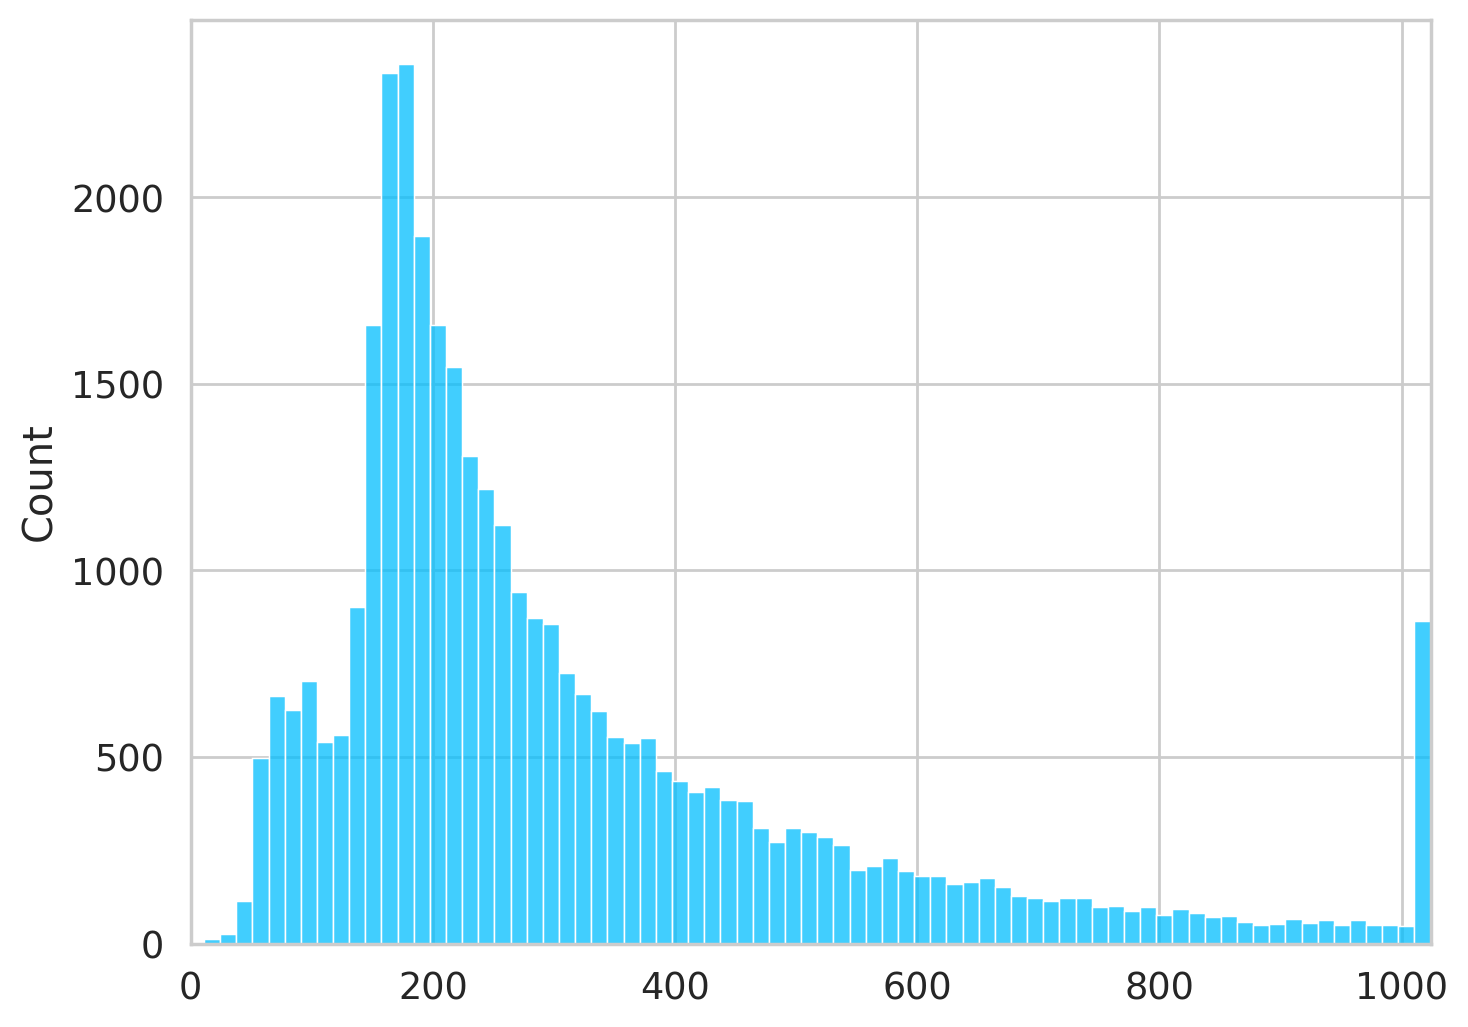

In [23]:
sns.histplot(token_counts)
plt.xlim([0, 1024]);

In [24]:
# Definimos hiperparámetro de máximo número de tokens en la secuencia
MAX_TOKEN_COUNT = 512

### Modulo Dataset que incluya el tokenizador


In [25]:
from utils.data import IMDBDataset

Tomando una muestra del Dataset:

In [26]:
# Usar la nueva clase IMDBDataset
train_dataset = IMDBDataset(train_df, tokenizer, max_token_len=MAX_TOKEN_COUNT)

sample_item = train_dataset[0]
sample_item.keys()

# Código original comentado:
# train_dataset = ToxicCommentsDataset(train_df, tokenizer, max_token_len=MAX_TOKEN_COUNT)

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [27]:
sample_item["comment_text"]

'Hello, I was wondering if anyone has a copy of the movie Broken Promise?? I loved this movie growing up and watched it every time it was on. It has been YEARS since I have seen it and would love to get a copy. I have checked all of the internet and have been unable to find it. If anyone has a copy to trade or sell em please email me at NoelGypsy@Yahoo.com... Thank you and have a great night!! Christine --------- The "broken promise" was made to eleven-year-old Melissa Michaelsen, whose parents have deserted her and her siblings. Taken in by the County, Michaelsen has had to watch helplessly as her brothers and sisters are split up and farmed out to different families. One of the kids is even institutionalized. Juvenile court officer Chris Sarandon joins Michaelsen in her struggle to reunite her family under one roof. Broken Promise was originally offered as a "General Foods Golden Showcase" presentation. It was first telecast May 5, 1981.'

In [28]:
sample_item["labels"]

tensor([0.])

In [29]:
# SentimentClassifier
from utils.model import SentimentClassifier

In [30]:
from utils.data import SentimentDataModule

In [31]:
# Configuración de entrenamiento actualizada para clasificación binaria IMDB
N_EPOCHS = 3  # Reducido para pruebas más rápidas
BATCH_SIZE = 16

# Crear DataModule
data_module = SentimentDataModule(
    train_df,
    val_df, 
    test_df,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

# Calcular pasos de entrenamiento
steps_per_epoch = len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Total training steps: {total_training_steps}")
print(f"Warmup steps: {warmup_steps}")

# Crear modelo
model = SentimentClassifier(
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

print("Modelo y DataModule creados exitosamente para clasificación de sentimientos IMDB")

Steps per epoch: 2187
Total training steps: 6561
Warmup steps: 1312
Modelo y DataModule creados exitosamente para clasificación de sentimientos IMDB


In [32]:
# Entrenar el modelo
import subprocess
import sys

# Ejecuta el script de entrenamiento usando subprocess
script_path = "training.py"

# Verificar que el script existe
if not os.path.exists(script_path):
    print(f"Error: No se encontró el archivo {script_path}")
    exit(1)

print("Iniciando entrenamiento del modelo BERT...")

try:
    # Ejecutar el script con subprocess
    process = subprocess.Popen(
        [sys.executable, script_path],
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
        universal_newlines=True,
        bufsize=1
    )
    
    # Mostrar la salida en tiempo real
    for line in process.stdout:
        print(line.rstrip())
    
    # Esperar a que termine el proceso
    process.wait()
    
    if process.returncode == 0:
        print("Entrenamiento completado exitosamente!")
    else:
        print("\n" + "=" * 60)
        print(f"Error durante el entrenamiento. Código de salida: {process.returncode}")
        
except Exception as e:
    print(f"Error al ejecutar el script: {str(e)}")

Iniciando entrenamiento del modelo BERT...


2025-09-06 22:41:31.443174: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757198491.465944 1041782 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757198491.473067 1041782 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757198491.491039 1041782 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757198491.491067 1041782 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1757198491.491070 1041782 computation_placer.cc:177] computation placer alr

In [ ]:
# Evaluación del modelo en el conjunto de prueba

# Cargar el mejor modelo
# best_model_path = checkpoint_callback.best_model_path
# best_model_path = './sentiment_checkpoints/best-checkpoint-epoch=01-val/loss=0.21.ckpt'
# best_model_path = './sentiment_checkpoints/best-checkpoint-epoch=02-val/loss=0.20.ckpt'
best_model_path = './sentiment_checkpoints/best-checkpoint-epoch=03-val/loss=0.22.ckpt'
print(f"Mejor modelo guardado en: {best_model_path}")

trained_model = SentimentClassifier.load_from_checkpoint(
    best_model_path,
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

# Determinar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

trainer = pl.Trainer(
    logger=False,
    accelerator="auto",  # Usa GPU si está disponible
    devices="auto",
    enable_checkpointing=False,
)

trainer.test(trained_model, data_module)


Mejor modelo guardado en: ./sentiment_checkpoints/best-checkpoint-epoch=03-val/loss=0.22.ckpt


INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Testing: |          | 0/? [00:00<?, ?it/s]

/home/eaguayo/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: TorchMetricsUserWarning: You are trying to use a metric in deterministic mode on GPU that uses `torch.cumsum`, which is currently not supported. The tensor will be copied to the CPU memory to compute it and then copied back to GPU. Expect some slowdowns.
  warnings.warn(*args, **kwargs)
/home/eaguayo/.local/lib/python3.10/site-packages/pytorch_lightning/core/module.py:520: You called `self.log('test/loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/eaguayo/.local/lib/python3.10/site-packages/pytorch_lightning/core/module.py:520: You called `self.log('test/auroc', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/eaguayo/.local/lib/python3.10/site-packages/pytorch_lightning/core/module.py:520: You called `self.log('test/accuracy', ..., logger=True)` but have no logge

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.9278666377067566     │
│        test/auroc         │     0.979088544845581     │
│         test/loss         │    0.20653203129768372    │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.20653203129768372,
  'test/auroc': 0.979088544845581,
  'test/accuracy': 0.9278666377067566}]

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

trained_model.eval()

print("Modelo listo para predicciones")

# Función para hacer predicciones en nuevos textos
def predict_sentiment(text, model, tokenizer, device, max_length=512):
    model.eval()
    
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    
    with torch.no_grad():
        _, outputs = model(input_ids, attention_mask)
        prediction = torch.sigmoid(outputs).cpu().numpy()[0][0]
    
    sentiment = "positive" if prediction > 0.5 else "negative" 
    confidence = prediction if prediction > 0.5 else 1 - prediction
    
    return sentiment, confidence

# Ejemplos de predicción
test_texts = [
    "This movie was absolutely fantastic! Great acting and amazing storyline.",
    "I hated this film. It was boring and poorly made.",
    "The movie was okay, nothing special but not terrible either.",
    "One of the best movies I've ever seen! Highly recommended!"
]

print("Predicciones en nuevos textos:")
print("-" * 80)

for text in test_texts:
    sentiment, confidence = predict_sentiment(text, trained_model, tokenizer, device)
    print(f"Text: {text}")
    print(f"Predicted sentiment: {sentiment.upper()}")
    print(f"Confidence: {confidence:.4f}")
    print("-" * 80)

Modelo listo para predicciones
Predicciones en nuevos textos:
--------------------------------------------------------------------------------
Text: This movie was absolutely fantastic! Great acting and amazing storyline.
Predicted sentiment: NEGATIVE
Confidence: 0.9892
--------------------------------------------------------------------------------
Text: I hated this film. It was boring and poorly made.
Predicted sentiment: POSITIVE
Confidence: 0.9814
--------------------------------------------------------------------------------
Text: The movie was okay, nothing special but not terrible either.
Predicted sentiment: POSITIVE
Confidence: 0.8563
--------------------------------------------------------------------------------
Text: One of the best movies I've ever seen! Highly recommended!
Predicted sentiment: NEGATIVE
Confidence: 0.9848
--------------------------------------------------------------------------------
